In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_absolute_percentage_error

In [ ]:
# 2. Đọc file csv và gắng index với giá Close
vcb = pd.read_csv('/content/VCB.csv',sep=";")
vcb1=vcb.reset_index()['Price']

In [ ]:
vcb1

0       22899
1       23169
2       22899
3       22738
4       22576
        ...  
1991    80900
1992    80900
1993    81800
1994    82800
1995    82700
Name: Price, Length: 1996, dtype: int64

In [ ]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
vcb1=scaler.fit_transform(np.array(vcb1).reshape(-1,1))

# 4. Chia train test
train_size = int(0.9 * len(vcb1))
test_size = len(vcb1) - train_size

train_data = vcb1[:train_size]
test_data = vcb1[train_size:train_size+test_size]

# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [ ]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 30
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# 7. Reshape input to be [samples, time steps, features] which is required for GRU
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [ ]:
# 8. Define GRU Model
model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# 9. Fit mô hình với dữ liệu train
model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1)

Epoch 1/100
28/28 [==============================] - 3s 21ms/step - loss: 0.0423
Epoch 2/100
28/28 [==============================] - 1s 21ms/step - loss: 0.0046
Epoch 3/100
28/28 [==============================] - 1s 21ms/step - loss: 6.9171e-04
Epoch 4/100
28/28 [==============================] - 1s 21ms/step - loss: 3.3401e-04
Epoch 5/100
28/28 [==============================] - 1s 20ms/step - loss: 3.1465e-04
Epoch 6/100
28/28 [==============================] - 1s 21ms/step - loss: 3.0309e-04
Epoch 7/100
28/28 [==============================] - 1s 20ms/step - loss: 2.9920e-04
Epoch 8/100
28/28 [==============================] - 1s 21ms/step - loss: 2.8549e-04
Epoch 9/100
28/28 [==============================] - 1s 21ms/step - loss: 2.8008e-04
Epoch 10/100
28/28 [==============================] - 1s 22ms/step - loss: 2.7209e-04
Epoch 11/100
28/28 [==============================] - 1s 31ms/step - loss: 2.6604e-04
Epoch 12/100
28/28 [==============================] - 1s 33ms/step - lo

In [ ]:
# 10. Dự báo dữ liệu test
y_pred=model.predict(X_test)
# 11. Chuẩn hóa dữ liệu y_pred
y_pred_new = scaler.inverse_transform(y_pred.reshape(1, -1))
y_test_new = scaler.inverse_transform(np.array([y_test], dtype=np.float32))

6/6 [==============================] - 1s 7ms/step


In [ ]:
# 12. Tính RMSE, MAPE, MAE
test_rmse = np.sqrt(np.mean((y_pred_new - y_test_new)**2))
print('RMSE:', test_rmse)
mape = mean_absolute_percentage_error(y_test_new, y_pred_new) * 100
print("MAPE:", mape)
msle = mean_squared_log_error(y_test_new, y_pred_new)
print("MSLE: ",  msle)

RMSE: 1699.6548
MAPE: 1.0521032847464085
MSLE:  0.00032189453


In [ ]:
#13 Dự đoán 30 ngày tiếp theo
x_input=test_data[60:].reshape(1,-1)

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=x_input.shape[1]
i=0
while(i<30):

    if(len(temp_input)>n_steps):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

[0.720555]
141
1 day input [0.95449348 0.96499498 0.98249749 0.94399197 0.92298896 0.9241558
 0.92882313 0.92298896 0.9241558  0.9241558  0.93699097 0.94632564
 0.9241558  0.9241558  0.9241558  0.94749247 0.93232363 0.98249749
 0.95566031 0.95916081 0.97082915 0.98133066 0.98249749 0.98016382
 0.97432965 1.         0.98249749 0.98249749 0.79077501 0.82730858
 0.84714476 0.83897692 0.84247742 0.82614175 0.82147441 0.82497491
 0.81447341 0.80863924 0.81680708 0.81564024 0.80980607 0.7899699
 0.81213974 0.79580407 0.79463723 0.79813773 0.8004714  0.80163823
 0.80513874 0.78880306 0.76429955 0.77246739 0.76313272 0.77246739
 0.78880306 0.7969709  0.7969709  0.80863924 0.80980607 0.80163823
 0.80163823 0.7899699  0.80630557 0.7969709  0.7969709  0.80513874
 0.7934704  0.78530256 0.78413573 0.77246739 0.79930457 0.79930457
 0.77246739 0.78180206 0.78413573 0.77830156 0.76663322 0.76429955
 0.76429955 0.74329654 0.75379804 0.74446337 0.76196588 0.76663322
 0.76079905 0.76780005 0.76196588 0.7

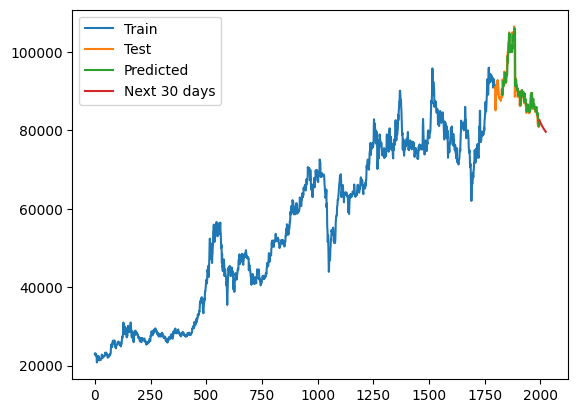

In [ ]:
# 14.Vẽ hình
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+31, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(y_pred))
prediect_data_index = pd.RangeIndex(start=len(vcb1)-1, stop=len(vcb1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predicted','Next 30 days'])
plt.show()

MB bank

In [2]:
# 2. Đọc file csv và gắng index với giá Price
mbb = pd.read_csv('/content/MBB.csv')
mbb1=mbb.reset_index()['Price']

In [3]:
mbb1

0        4894
1        4929
2        4859
3        4824
4        4789
        ...  
1991    18150
1992    18300
1993    18400
1994    18450
1995    18400
Name: Price, Length: 1996, dtype: int64

In [4]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
mbb1=scaler.fit_transform(np.array(mbb1).reshape(-1,1))

# 4. Chia train test
train_size = int(0.9 * len(mbb1))
test_size = len(mbb1) - train_size

train_data = mbb1[:train_size]
test_data = mbb1[train_size:train_size+test_size]

# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [5]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 30
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# 7. Reshape input to be [samples, time steps, features] which is required for GRU
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [6]:
# 8. Define GRU Model
model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# 9. Fit mô hình với dữ liệu train
model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1)

Epoch 1/100
28/28 [==============================] - 4s 26ms/step - loss: 0.0475
Epoch 2/100
28/28 [==============================] - 1s 24ms/step - loss: 0.0037
Epoch 3/100
28/28 [==============================] - 1s 23ms/step - loss: 4.8921e-04
Epoch 4/100
28/28 [==============================] - 1s 29ms/step - loss: 4.1195e-04
Epoch 5/100
28/28 [==============================] - 0s 17ms/step - loss: 3.8360e-04
Epoch 6/100
28/28 [==============================] - 0s 16ms/step - loss: 3.6331e-04
Epoch 7/100
28/28 [==============================] - 0s 17ms/step - loss: 3.5252e-04
Epoch 8/100
28/28 [==============================] - 1s 30ms/step - loss: 3.4094e-04
Epoch 9/100
28/28 [==============================] - 1s 38ms/step - loss: 3.3820e-04
Epoch 10/100
28/28 [==============================] - 1s 30ms/step - loss: 3.1758e-04
Epoch 11/100
28/28 [==============================] - 1s 29ms/step - loss: 3.0864e-04
Epoch 12/100
28/28 [==============================] - 1s 30ms/step - lo

In [7]:
# 10. Dự báo dữ liệu test
y_pred=model.predict(X_test)
# 11. Chuẩn hóa dữ liệu y_pred
y_pred_new = scaler.inverse_transform(y_pred.reshape(1, -1))
y_test_new = scaler.inverse_transform(np.array([y_test], dtype=np.float32))

6/6 [==============================] - 0s 5ms/step


In [8]:
# 12. Tính RMSE, MAPE, MAE
test_rmse = np.sqrt(np.mean((y_pred_new - y_test_new)**2))
print('RMSE:', test_rmse)
mape = mean_absolute_percentage_error(y_test_new, y_pred_new) * 100
print("MAPE:", mape)
msle = mean_squared_log_error(y_test_new, y_pred_new)
print("MSLE: ",  msle)

RMSE: 373.744
MAPE: 1.3627951964735985
MSLE:  0.00038305979


In [9]:
#13 Dự đoán 30 ngày tiếp theo
x_input=test_data[60:].reshape(1,-1)

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=x_input.shape[1]
i=0
while(i<30):

    if(len(temp_input)>n_steps):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

[0.58089566]
141
1 day input [0.62873678 0.62665501 0.62665501 0.62040969 0.62457324 0.63290032
 0.6349821  0.64747273 0.64747273 0.64330918 0.66829045 0.65163627
 0.64747273 0.64747273 0.65371804 0.65579982 0.64747273 0.65788159
 0.67037222 0.68910817 0.68078108 0.57036389 0.5829378  0.58085602
 0.58085602 0.57252894 0.57461071 0.5829378  0.58710134 0.58918311
 0.58710134 0.58085602 0.58501957 0.59126488 0.59126488 0.59334666
 0.59126488 0.5975102  0.6120826  0.60583729 0.60375552 0.59334666
 0.59334666 0.59542843 0.59542843 0.5975102  0.59126488 0.5600383
 0.56212008 0.56420185 0.55587476 0.56628362 0.5600383  0.56420185
 0.56628362 0.57252894 0.57669248 0.60375552 0.60791906 0.61000083
 0.60167374 0.58710134 0.60791906 0.59959197 0.60375552 0.61416438
 0.60375552 0.5975102  0.60583729 0.59542843 0.58501957 0.5600383
 0.56628362 0.57669248 0.57669248 0.57669248 0.58085602 0.55795653
 0.56212008 0.55795653 0.56212008 0.56836539 0.57461071 0.57669248
 0.57044716 0.57461071 0.56420185 0

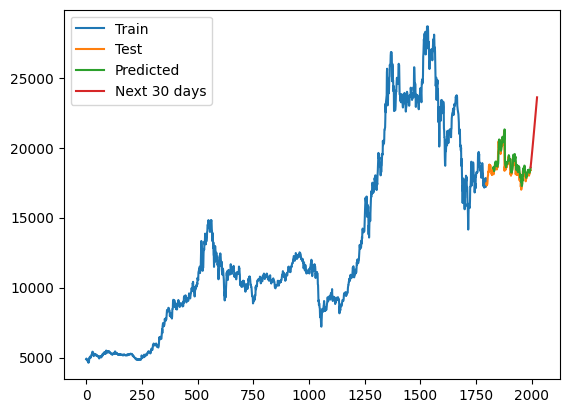

In [10]:
# 14.Vẽ hình
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+31, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(y_pred))
prediect_data_index = pd.RangeIndex(start=len(mbb1)-1, stop=len(mbb1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predicted','Next 30 days'])
plt.show()

BIDV

In [11]:
# 2. Đọc file csv và gắng index với giá Close
bidv = pd.read_csv('/content/BIDV.csv')
bidv1=bidv.reset_index()['Price']

In [12]:
bidv1

0       14155
1       14225
2       13592
3       13240
4       13380
        ...  
1991    41800
1992    42450
1993    43200
1994    43000
1995    43000
Name: Price, Length: 1996, dtype: int64

In [13]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
bidv1=scaler.fit_transform(np.array(bidv1).reshape(-1,1))

# 4. Chia train test
train_size = int(0.9 * len(bidv1))
test_size = len(bidv1) - train_size

train_data = bidv1[:train_size]
test_data =bidv1[train_size:train_size+test_size]

# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [14]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 30
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# 7. Reshape input to be [samples, time steps, features] which is required for GRU
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [15]:
# 8. Define GRU Model
model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# 9. Fit mô hình với dữ liệu train
model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1)

Epoch 1/100
28/28 [==============================] - 3s 17ms/step - loss: 0.0449
Epoch 2/100
28/28 [==============================] - 0s 18ms/step - loss: 0.0048
Epoch 3/100
28/28 [==============================] - 0s 18ms/step - loss: 0.0010
Epoch 4/100
28/28 [==============================] - 0s 17ms/step - loss: 6.4384e-04
Epoch 5/100
28/28 [==============================] - 0s 17ms/step - loss: 6.0712e-04
Epoch 6/100
28/28 [==============================] - 1s 18ms/step - loss: 5.8861e-04
Epoch 7/100
28/28 [==============================] - 0s 17ms/step - loss: 5.6826e-04
Epoch 8/100
28/28 [==============================] - 0s 18ms/step - loss: 5.5266e-04
Epoch 9/100
28/28 [==============================] - 0s 17ms/step - loss: 5.3269e-04
Epoch 10/100
28/28 [==============================] - 1s 18ms/step - loss: 5.2454e-04
Epoch 11/100
28/28 [==============================] - 1s 18ms/step - loss: 5.1047e-04
Epoch 12/100
28/28 [==============================] - 1s 18ms/step - loss: 

In [16]:
# 10. Dự báo dữ liệu test
y_pred=model.predict(X_test)
# 11. Chuẩn hóa dữ liệu y_pred
y_pred_new = scaler.inverse_transform(y_pred.reshape(1, -1))
y_test_new = scaler.inverse_transform(np.array([y_test], dtype=np.float32))

6/6 [==============================] - 0s 5ms/step


In [17]:
# 12. Tính RMSE, MAPE, MAE
test_rmse = np.sqrt(np.mean((y_pred_new - y_test_new)**2))
print('RMSE:', test_rmse)
mape = mean_absolute_percentage_error(y_test_new, y_pred_new) * 100
print("MAPE:", mape)
msle = mean_squared_log_error(y_test_new, y_pred_new)
print("MSLE: ",  msle)

RMSE: 761.7535
MAPE: 1.2115360237658024
MSLE:  0.00030745773


In [18]:
#13 Dự đoán 30 ngày tiếp theo
x_input=test_data[60:].reshape(1,-1)

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=x_input.shape[1]
i=0
while(i<30):

    if(len(temp_input)>n_steps):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

[0.848398]
141
1 day input [0.86776945 0.86388032 0.85999118 0.84962016 0.85480567 0.85221292
 0.86647307 0.87554772 0.87554772 0.87554772 0.90277166 0.88073323
 0.85091654 0.88073323 0.86776945 0.8768441  0.86647307 0.87554772
 0.94425575 0.93388473 0.93777386 0.94295937 0.93907024 0.92481008
 0.93777386 0.92610646 0.92610646 0.93907024 0.94036662 0.94944126
 0.95462677 0.93777386 0.93777386 0.95073764 0.9766652  1.
 0.98573984 0.98185071 0.99351811 0.9883326  0.9766652  0.93258835
 0.93777386 0.96110866 0.94555213 0.95851591 0.94814488 0.87295496
 0.90925355 0.91443906 0.9118463  0.91443906 0.89888252 0.90406803
 0.91443906 0.92481008 0.94425575 0.95851591 0.95333039 0.95462677
 0.94555213 0.93258835 0.94555213 0.94555213 0.93907024 0.94036662
 0.91314268 0.89888252 0.9118463  0.89888252 0.92092095 0.89628977
 0.8768441  0.87814048 0.8768441  0.8768441  0.86647307 0.80424693
 0.82887811 0.80554331 0.82109985 0.81461796 0.81721071 0.81591434
 0.81980347 0.82887811 0.80683969 0.7977650

In [21]:
scaler.inverse_transform(lst_output)

array([[43252.86131263],
       [43457.36380774],
       [43667.11007446],
       [43877.85176122],
       [44088.77506042],
       [44299.46617156],
       [44509.61474431],
       [44718.92881942],
       [44927.15781772],
       [45134.06495339],
       [45339.41344059],
       [45543.0170691 ],
       [45744.67813426],
       [45944.18973583],
       [46141.37945694],
       [46336.07258183],
       [46528.1058892 ],
       [46717.34144557],
       [46903.61832851],
       [47086.79860455],
       [47266.78112245],
       [47443.44404095],
       [47616.68390995],
       [47786.39268154],
       [47952.46230781],
       [48114.81232756],
       [48273.36687738],
       [48428.03859937],
       [48578.7585268 ],
       [48725.48068184]])

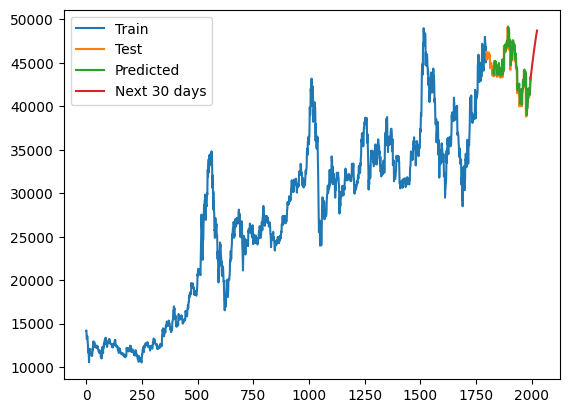

In [20]:
# 14.Vẽ hình
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+31, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(y_pred))
prediect_data_index = pd.RangeIndex(start=len(bidv1)-1, stop=len(bidv1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predicted','Next 30 days'])
plt.show()